In [144]:
import requests

url = "https://raw.githubusercontent.com/dthomas1108/year4-data-visualisation-assignment/refs/heads/master/collision2017.csv"
r = requests.get(url)

with open("file.csv", "wb") as f:
    f.write(r.content)

In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyproj import Transformer
from dash import Dash, dcc, html, Input, Output, ctx
import plotly.express as px
import webview
from threading import Thread
from time import sleep
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_moons
import plotly.graph_objects as go
import folium

<H1>Collision Data</H1>
<h2>Reading and Cleaning</h2>

In [5]:
csv_path = 'collision2017.csv'

dfCol = pd.read_csv(csv_path)

display(dfCol.head(10))
print('Shape:', dfCol.shape)
print('Columns:', list(dfCol.columns))

a_year  a_ref a_District  a_type  a_veh  a_cas a_wkday  a_day  a_month  \
0    2017      1       NEMD       3      1      1     SUN      1        1   
1    2017      2       MEAN       3      2      1     SUN      1        1   
2    2017      3       ARBC       2      1      1     SUN      1        1   
3    2017      4       ANTN       3      2      1     SUN      1        1   
4    2017      5       ANTN       2      2      2     SUN      1        1   
5    2017      6       ARND       3      2      4     SUN      1        1   
6    2017      7       LISC       3      3      1     SUN      1        1   
7    2017      8       MEAN       2      1      2     SUN      1        1   
8    2017      9       CCGL       2      1      1     MON      2        1   
9    2017     10       MEAN       2      3      4     MON      2        1   

   a_hour  ...  a_jdet  a_jcont  a_pedhum  a_pedphys  a_light a_weat a_roadsc  \
0       3  ...                                                                  
1       3  ...                                                                  
2      10  ...       2        7         1          1        2     10        1   
3      10  ...                                                                  
4      11  ...       1        1         1          1        2      1        1   
5      12  ...                                                                  
6      13  ...                                                                  
7      17  ...       1        1         1          1        2      1        2   
8       8  ...      10        7         1          1        1      1        4   
9       9  ...      10        7         1          1        2      9        4   

  a_speccs a_chaz a_scene  
0                          
1                          
2        1      1       1  
3                          
4        1      1       1  
5                          
6                          
7        1      1       1  
8        1      1       1  
9        1      1       1  

[10 rows x 25 columns]

Shape: (6081, 25)
Columns: ['a_year', 'a_ref', 'a_District', 'a_type', 'a_veh', 'a_cas', 'a_wkday', 'a_day', 'a_month', 'a_hour', 'a_min', 'a_gd1', 'a_gd2', 'a_ctype', 'a_speed', 'a_jdet', 'a_jcont', 'a_pedhum', 'a_pedphys', 'a_light', 'a_weat', 'a_roadsc', 'a_speccs', 'a_chaz', 'a_scene']


In [6]:
dfCol.dtypes

a_year         int64
a_ref          int64
a_District    object
a_type         int64
a_veh          int64
a_cas          int64
a_wkday       object
a_day          int64
a_month        int64
a_hour         int64
a_min          int64
a_gd1          int64
a_gd2          int64
a_ctype        int64
a_speed        int64
a_jdet        object
a_jcont       object
a_pedhum      object
a_pedphys     object
a_light       object
a_weat        object
a_roadsc      object
a_speccs      object
a_chaz        object
a_scene       object
dtype: object

In [146]:
# Detect duplicate rows based on the 'a_ref' column
duplicate_rows = dfCol[dfCol.duplicated(subset='a_ref', keep=False)]

# Print the duplicate rows
print("Duplicate rows based on 'a_ref':")
display(duplicate_rows)

Duplicate rows based on 'a_ref':


Empty DataFrame
Columns: [a_year, a_ref, a_District, a_type, a_veh, a_cas, a_wkday, a_day, a_month, a_hour, a_min, a_gd1, a_gd2, a_ctype, a_speed, a_jdet, a_jcont, a_pedhum, a_pedphys, a_light, a_weat, a_roadsc, a_speccs, a_chaz, a_scene, longitude, latitude, a_kmspeed]
Index: []

[0 rows x 28 columns]

### The Above should be empty showing 0 duplicates <br> <br>The Below shows the Unique string values (exluding numeric catorgarised as Strings)

In [8]:
# Display the unique values for string columns (excuding numberic catorgaised as strings)
for col in dfCol.columns:
    if dfCol[col].dtype == 'object'and col not in ['a_jdet', 'a_jcont','a_pedhum','a_light','a_weat','a_roadsc','a_speccs','a_chaz','a_scene','a_pedphys']:
        unique_values = dfCol[col].unique()
        print(f"Unique values for '{col}':")
        display(unique_values[:20])

Unique values for 'a_District':


array(['NEMD', 'MEAN', 'ARBC', 'ANTN', 'ARND', 'LISC', 'CCGL', 'DCST',
       'BELC', 'MIDU', 'FERO'], dtype=object)

Unique values for 'a_wkday':


array(['SUN', 'MON', 'TUE', 'WED', 'THU', 'FRI', 'SAT'], dtype=object)

### adding NaN
### Step 1: Quantify Missingness

In [9]:
# Define the values to consider as missing
missing_values = [' ','', 'Unknown', np.nan]

# Iterate through each column and count missing values
for col in dfCol.columns:
    if col in ['a_District','a_wkday']: continue
    missing_count = dfCol[col].isin(missing_values).sum() + dfCol[col].isna().sum()
    if missing_count > 0:
        print(f"Column '{col}': {missing_count} missing values")

Column 'a_jdet': 5376 missing values
Column 'a_jcont': 5376 missing values
Column 'a_pedhum': 5376 missing values
Column 'a_pedphys': 5376 missing values
Column 'a_light': 5376 missing values
Column 'a_weat': 5376 missing values
Column 'a_roadsc': 5376 missing values
Column 'a_speccs': 5376 missing values
Column 'a_chaz': 5376 missing values
Column 'a_scene': 5376 missing values


### 10 Columns are missing 5376 values (Over 88% of each of these columns is missing), this is substantial. Could these the accidents Police wherent called to?<br>
### Step 2: replace missing with NaN

In [10]:
missing_values = [' ','', 'Unknown', np.nan]
dfCol.replace(missing_values, np.nan, inplace=True)
dfCol.head(10)

a_year  a_ref a_District  a_type  a_veh  a_cas a_wkday  a_day  a_month  \
0    2017      1       NEMD       3      1      1     SUN      1        1   
1    2017      2       MEAN       3      2      1     SUN      1        1   
2    2017      3       ARBC       2      1      1     SUN      1        1   
3    2017      4       ANTN       3      2      1     SUN      1        1   
4    2017      5       ANTN       2      2      2     SUN      1        1   
5    2017      6       ARND       3      2      4     SUN      1        1   
6    2017      7       LISC       3      3      1     SUN      1        1   
7    2017      8       MEAN       2      1      2     SUN      1        1   
8    2017      9       CCGL       2      1      1     MON      2        1   
9    2017     10       MEAN       2      3      4     MON      2        1   

   a_hour  ...  a_jdet  a_jcont  a_pedhum  a_pedphys  a_light a_weat a_roadsc  \
0       3  ...     NaN      NaN       NaN        NaN      NaN    NaN      NaN   
1       3  ...     NaN      NaN       NaN        NaN      NaN    NaN      NaN   
2      10  ...       2        7         1          1        2     10        1   
3      10  ...     NaN      NaN       NaN        NaN      NaN    NaN      NaN   
4      11  ...       1        1         1          1        2      1        1   
5      12  ...     NaN      NaN       NaN        NaN      NaN    NaN      NaN   
6      13  ...     NaN      NaN       NaN        NaN      NaN    NaN      NaN   
7      17  ...       1        1         1          1        2      1        2   
8       8  ...      10        7         1          1        1      1        4   
9       9  ...      10        7         1          1        2      9        4   

  a_speccs a_chaz a_scene  
0      NaN    NaN     NaN  
1      NaN    NaN     NaN  
2        1      1       1  
3      NaN    NaN     NaN  
4        1      1       1  
5      NaN    NaN     NaN  
6      NaN    NaN     NaN  
7        1      1       1  
8        1      1       1  
9        1      1       1  

[10 rows x 25 columns]

<Axes: >

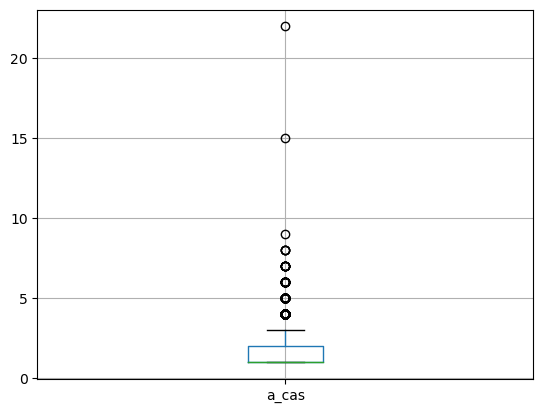

In [11]:
#boxplot of casuiltys
dfCol[['a_cas']].boxplot()

### As expected there are no Negative Casulties, but there is 2 dots that are outliers, at the 15 and 22/23(?) position <br>
### We will keep this data as knowing the location of the most serious/hightest casulty colisions is of high importance

### Maping values to decrease cognative Load
####  a_type: map 1,2,3 to Fatal,Serious,Slight

In [12]:
a_type_map = {
    1: "Fatal", 2: "Serious", 3: "Slight",
}

dfCol['a_type'] = dfCol['a_type'].replace(a_type_map)
dfCol.head(5)

a_year  a_ref a_District   a_type  a_veh  a_cas a_wkday  a_day  a_month  \
0    2017      1       NEMD   Slight      1      1     SUN      1        1   
1    2017      2       MEAN   Slight      2      1     SUN      1        1   
2    2017      3       ARBC  Serious      1      1     SUN      1        1   
3    2017      4       ANTN   Slight      2      1     SUN      1        1   
4    2017      5       ANTN  Serious      2      2     SUN      1        1   

   a_hour  ...  a_jdet  a_jcont  a_pedhum  a_pedphys  a_light a_weat a_roadsc  \
0       3  ...     NaN      NaN       NaN        NaN      NaN    NaN      NaN   
1       3  ...     NaN      NaN       NaN        NaN      NaN    NaN      NaN   
2      10  ...       2        7         1          1        2     10        1   
3      10  ...     NaN      NaN       NaN        NaN      NaN    NaN      NaN   
4      11  ...       1        1         1          1        2      1        1   

  a_speccs a_chaz a_scene  
0      NaN    NaN     NaN  
1      NaN    NaN     NaN  
2        1      1       1  
3      NaN    NaN     NaN  
4        1      1       1  

[5 rows x 25 columns]

#### a_ctype: Map values from the data guide (Carriage way type)
#### a_jdet: Map values from the data guide (Junction Detail)
#### a_weat: Map values from the data guide (Weather Conditions)
#### a_light: Map values from the data guide (Light Conditions)
#### a_roadsc: Map values from the data guide (Road Surface Conditions)

#### (data guide @ https://admin.opendatani.gov.uk/dataset/police-recorded-injury-road-traffic-collision-statistics-northern-ireland-2017/resource/de8384e7-95c8-4e35-910b-ce919db78024 )


In [134]:
a_ctype_map = {
    1: "Roundabout", 2: "One way street", 10: "Other / unknown",11:"Dual carriageway",12:"Motorway",13:"Single carriageway",14:"Slip road",
}
a_jdet_map = {
    '1': "Not at or within 20m of junction", '2': "Roundabout", '3': "Mini-roundabout",'6':"Crossroads",'8':"Multiple junction",'9':"Slip road",'10':"Private drive / entrance",'11':"Other junction",'12':"T or staggered junction"
}
a_weat_map = {
    '1': "Fine without high winds", '2': "Raining without high winds", '3': "Snowing without high winds",'4':"Fine with high winds",'5':"Raining with high winds",'6':"Snowing with high winds",'7':"Fog or mist - if hazard",'8':"Strong sun (glaring)",'9':'Other','10':"Unknown"
}
a_light_map = {
    '1': "Daylight: street lights present", '2': "Daylight: no street lighting", '3': "Daylight: street lighting unknown",'4':"Darkness: street lights present and lit",'5':"Darkness: street lights present but unlit",'6':"Darkness: no street lighting",'7':"Darkness: street lighting unknown",
}
a_roadsc_map = {
    '1': "Dry", '2': "Wet / damp", '3': "Snow",'4':"Frost / ice",'5':"Flood",'6':"Oil",'7':"Mud",'8':"Leaves",'9':'Slippery (after dry spell)','10':"Other"
}
dfCol['a_ctype'] = dfCol['a_ctype'].replace(a_ctype_map)
dfCol['a_jdet'] = dfCol['a_jdet'].replace(a_jdet_map)
dfCol['a_weat'] = dfCol['a_weat'].replace(a_weat_map)
dfCol['a_light'] = dfCol['a_light'].replace(a_light_map)
dfCol['a_roadsc'] = dfCol['a_roadsc'].replace(a_roadsc_map)
dfCol.head(5)

a_year  a_ref a_District   a_type  a_veh  a_cas a_wkday  a_day  a_month  \
0    2017      1       NEMD   Slight      1      1     SUN      1        1   
1    2017      2       MEAN   Slight      2      1     SUN      1        1   
2    2017      3       ARBC  Serious      1      1     SUN      1        1   
3    2017      4       ANTN   Slight      2      1     SUN      1        1   
4    2017      5       ANTN  Serious      2      2     SUN      1        1   

   a_hour  ...  a_pedphys                       a_light  \
0       3  ...        NaN                           NaN   
1       3  ...        NaN                           NaN   
2      10  ...          1  Daylight: no street lighting   
3      10  ...        NaN                           NaN   
4      11  ...          1  Daylight: no street lighting   

                    a_weat a_roadsc a_speccs a_chaz a_scene longitude  \
0                      NaN      NaN      NaN    NaN     NaN -5.863640   
1                      NaN      NaN      NaN    NaN     NaN -6.363452   
2                      NaN      Dry        1      1       1 -6.639651   
3                      NaN      NaN      NaN    NaN     NaN -5.909253   
4  Fine without high winds      Dry        1      1       1 -6.235357   

    latitude a_kmspeed  
0  54.281742   96.5604  
1  54.851131   48.2802  
2  54.353228   48.2802  
3  54.657811   48.2802  
4  54.743628   96.5604  

[5 rows x 28 columns]

### Add Km row (speed limits in km)

In [116]:
dfCol['a_kmspeed'] = float(dfCol['a_speed'] * 1.60934)

#### Make those rows catagorical

In [117]:
# Example: set some columns to categorical
for cat_col in ['a_type', 'a_ctype', 'a_jdet', 'a_weat','a_light','a_speed']:
    if cat_col in dfCol.columns:
        dfCol[cat_col] = dfCol[cat_col].astype('category')
dfCol[['a_type', 'a_ctype', 'a_jdet', 'a_weat','a_light','a_speed']].info() # It should be category

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6081 entries, 0 to 6080
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   a_type   6081 non-null   category
 1   a_ctype  6081 non-null   category
 2   a_jdet   705 non-null    category
 3   a_weat   633 non-null    category
 4   a_light  705 non-null    category
 5   a_speed  6081 non-null   category
dtypes: category(6)
memory usage: 37.5 KB


<H1>Vehicle Data</H1>
<h2>Reading and Cleaning</h2>

In [15]:
csv_path = 'vehicle2017.csv'

dfVeh = pd.read_csv(csv_path)

display(dfVeh.head(10))
print('Shape:', dfVeh.shape)
print('Columns:', list(dfVeh.columns))

a_year  a_ref  v_id  v_type  v_tow  v_man  v_loc v_junc v_skid v_hit  \
0    2017      1     1       8      1     18      3                       
1    2017      2     1       8      1     10      3                       
2    2017      2     2       8      1     18      3                       
3    2017      3     1       8      1     18      3      3      1     1   
4    2017      4     1       8      1     18      3                       
5    2017      4     2       8      1      2      3                       
6    2017      5     1       8      1     13      3      1      1     1   
7    2017      5     2       8      1      3      6      1      1     1   
8    2017      6     1       8      1      9      3                       
9    2017      6     2       8      1     13      3                       

  v_leave v_hitoff  v_impact v_sex v_agegroup  v_hitr v_forreg  
0                          2     1          6       1           
1                          3     1          7       1           
2                          2     1          6       2           
3       1        1         2     1          7       1        1  
4                          2     1          8       1           
5                          4                9       1           
6       1        1         2     1          5       1        1  
7       1        1         2     1          5       1        1  
8                          4     1          7       1           
9                          2     1          8       1

Shape: (11299, 17)
Columns: ['a_year', 'a_ref', 'v_id', 'v_type', 'v_tow', 'v_man', 'v_loc', 'v_junc', 'v_skid', 'v_hit', 'v_leave', 'v_hitoff', 'v_impact', 'v_sex', 'v_agegroup', 'v_hitr', 'v_forreg']


In [16]:
dfVeh.dtypes

a_year         int64
a_ref          int64
v_id           int64
v_type         int64
v_tow          int64
v_man          int64
v_loc          int64
v_junc        object
v_skid        object
v_hit         object
v_leave       object
v_hitoff      object
v_impact       int64
v_sex         object
v_agegroup    object
v_hitr         int64
v_forreg      object
dtype: object

### We already checked for duplicate collisions
### adding NaN
### Step 1: Quantify Missingness

In [17]:
# Define the values to consider as missing
missing_values = [' ','', 'Unknown', np.nan]

# Iterate through each column and count missing values
for col in dfVeh.columns:
    if col in ['a_District','a_wkday']: continue
    missing_count = dfVeh[col].isin(missing_values).sum() + dfVeh[col].isna().sum()
    if missing_count > 0:
        print(f"Column '{col}': {missing_count} missing values")

Column 'v_junc': 10157 missing values
Column 'v_skid': 10157 missing values
Column 'v_hit': 10157 missing values
Column 'v_leave': 10157 missing values
Column 'v_hitoff': 10157 missing values
Column 'v_sex': 611 missing values
Column 'v_agegroup': 1 missing values
Column 'v_forreg': 10170 missing values


### 6 Columns are missing 10157 values (Nearly 90% of each of these columns is missing), this is substantial. There is also data missing from on sex of the driver and one instance of age of the driver<br>
### Step 2: replace missing with NaN

In [18]:
missing_values = [' ','', 'Unknown', np.nan]
dfVeh.replace(missing_values, np.nan, inplace=True)
dfVeh.head(10)

a_year  a_ref  v_id  v_type  v_tow  v_man  v_loc v_junc v_skid v_hit  \
0    2017      1     1       8      1     18      3    NaN    NaN   NaN   
1    2017      2     1       8      1     10      3    NaN    NaN   NaN   
2    2017      2     2       8      1     18      3    NaN    NaN   NaN   
3    2017      3     1       8      1     18      3      3      1     1   
4    2017      4     1       8      1     18      3    NaN    NaN   NaN   
5    2017      4     2       8      1      2      3    NaN    NaN   NaN   
6    2017      5     1       8      1     13      3      1      1     1   
7    2017      5     2       8      1      3      6      1      1     1   
8    2017      6     1       8      1      9      3    NaN    NaN   NaN   
9    2017      6     2       8      1     13      3    NaN    NaN   NaN   

  v_leave v_hitoff  v_impact v_sex v_agegroup  v_hitr v_forreg  
0     NaN      NaN         2     1          6       1      NaN  
1     NaN      NaN         3     1          7       1      NaN  
2     NaN      NaN         2     1          6       2      NaN  
3       1        1         2     1          7       1        1  
4     NaN      NaN         2     1          8       1      NaN  
5     NaN      NaN         4   NaN          9       1      NaN  
6       1        1         2     1          5       1        1  
7       1        1         2     1          5       1        1  
8     NaN      NaN         4     1          7       1      NaN  
9     NaN      NaN         2     1          8       1      NaN

### Maping values to decrease cognative Load
#### v_type: map 1,2...25 to Unknown,Pedal cycle...Agricultural vehicle
#### v_man: Map values from the data guide (Vehicle Manoeuvre)
#### v_impact: Map values from the data guide (First point of impact)
#### v_sex: Map values from the data guide (Sex of Driver)
#### v_agegroup: Map values from the data guide (Age of Driver)

#### (data guide @ https://admin.opendatani.gov.uk/dataset/police-recorded-injury-road-traffic-collision-statistics-northern-ireland-2017/resource/de8384e7-95c8-4e35-910b-ce919db78024 )


In [40]:
## Yeah Baby, I'm bACK and I'm clearing up the code I left in a HOT MESS last night (LET ME SLEEP) PLS GIVE EXSTENTION 

v_type_map = {
    0: "Unknown", 1: "Pedal cycle",2:"Motorcycle - moped",4:"Motorcycle (under 125cc)", 5:"Motorcycle (125cc and above)",6:'Invalid vehicle / other 3 wheeler',7:"Car - taxi (hackney)",8:"Car",9:"Motor caravan", 14:"Other motor vehicle",15: "Goods 3.5 tonnes or less",16:"Goods exceeding 3.5 tonnes but less than 7.5 tonnes",17:"Goods 7.5 tonnes or over",18:"Car (used as taxi)",19:"Minibus (8-16 passengers)",20:"Bus or coach (17+ passengers)",21:"Ridden horse",22:"Other non motor vehicle",23:"Motorcycle (engine size unknown)",24:"Goods vehicle (gross weight unknown)",25:"Agricultural vehicle"
}
v_man_map = {
    1: "Reversing", 2: "Parked", 3: "About to go ahead - held up",4:"Slowing / stopping",5:"Moving off",6:"U-turn",7:"Turning left",8:"Waiting to turn left",9:"Turning right",10:"Waiting to turn right",11:"Changing lane to left",12:"Changing lane to right",13:"Overtaking moving vehicle on offside",14:"Overtaking stationary vehicle on offside",15:"Overtaking on nearside",16:"Going ahead left-hand bend",17:"Going ahead right-hand bend",18:"Going ahead other",19:"Other / not known"
}
v_impact_map = {
    1: "Did not impact", 2: "Front", 3: "Back",4:"Offside",5:"Nearside"
}
v_sex_map = {
    '1': "Male", '2': "Female", '3': "Unknown"
}
v_agegroup_map = {
    '1':"Under 10",'2':"10-16",'3':"17-24","4":"25-34","5":"35-44",'6':"45-54","7":"55-64","8":"65+","9":"Unknown"
}
dfVeh['v_type'] = dfVeh['v_type'].replace(v_type_map)
dfVeh['v_man'] = dfVeh['v_man'].replace(v_man_map)
dfVeh['v_impact'] = dfVeh['v_impact'].replace(v_impact_map)
dfVeh['v_sex'] = dfVeh['v_sex'].replace(v_sex_map)
dfVeh['v_agegroup'] = dfVeh['v_agegroup'].replace(v_agegroup_map)
dfVeh.head(5)

a_year  a_ref  v_id v_type  v_tow                  v_man  v_loc v_junc  \
0    2017      1     1    Car      1      Going ahead other      3    NaN   
1    2017      2     1    Car      1  Waiting to turn right      3    NaN   
2    2017      2     2    Car      1      Going ahead other      3    NaN   
3    2017      3     1    Car      1      Going ahead other      3      3   
4    2017      4     1    Car      1      Going ahead other      3    NaN   

  v_skid v_hit v_leave v_hitoff v_impact v_sex v_agegroup  v_hitr v_forreg  \
0    NaN   NaN     NaN      NaN    Front  Male      45-54       1      NaN   
1    NaN   NaN     NaN      NaN     Back  Male      55-64       1      NaN   
2    NaN   NaN     NaN      NaN    Front  Male      45-54       2      NaN   
3      1     1       1        1    Front  Male      55-64       1        1   
4    NaN   NaN     NaN      NaN    Front  Male        65+       1      NaN   

   v_man_map  
0         18  
1         10  
2         18  
3         18  
4         18

#### Make those rows catagorical

In [42]:
# Example: set some columns to categorical
for cat_col in ['v_type', 'v_man', 'v_impact', 'v_sex','v_agegroup']:
    if cat_col in dfVeh.columns:
        dfVeh[cat_col] = dfVeh[cat_col].astype('category')
dfVeh[['v_type', 'v_man', 'v_impact', 'v_sex','v_agegroup']].info() # It should be category

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11299 entries, 0 to 11298
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   v_type      11299 non-null  category
 1   v_man       11299 non-null  category
 2   v_impact    11299 non-null  category
 3   v_sex       10688 non-null  category
 4   v_agegroup  11298 non-null  category
dtypes: category(5)
memory usage: 57.4 KB


<H1>Casualty Data</H1>
<h2>Reading and Cleaning</h2>

In [44]:
csv_path = 'casualty2017.csv'

dfCas = pd.read_csv(csv_path)

display(dfCas.head(10))
print('Shape:', dfCas.shape)
print('Columns:', list(dfCas.columns))

a_year  a_ref  v_id  c_id  c_class  c_sex  c_agegroup  c_sever c_loc  \
0    2017      1     1     1        1      1           6        3         
1    2017      2     1     1        1      1           7        3         
2    2017      3     0     1        5      1           8        2     6   
3    2017      4     1     1        1      1           8        3         
4    2017      5     1     1        1      1           5        2     1   
5    2017      5     2     2        1      1           5        2     1   
6    2017      6     1     1        1      1           7        3         
7    2017      6     1     2        4      2           5        3         
8    2017      6     2     3        1      1           8        3         
9    2017      6     2     4        3      2           7        3         

  c_move  c_school c_pcv c_pedinj c_vtype  
0                8                      8  
1                8                      8  
2      6         8     1        2          
3                8                      8  
4      1         8     1                8  
5      1         8     1                8  
6                8                      8  
7                8                      8  
8                8                      8  
9                8                      8

Shape: (9184, 14)
Columns: ['a_year', 'a_ref', 'v_id', 'c_id', 'c_class', 'c_sex', 'c_agegroup', 'c_sever', 'c_loc', 'c_move', 'c_school', 'c_pcv', 'c_pedinj', 'c_vtype']


In [45]:
dfVeh.dtypes

a_year           int64
a_ref            int64
v_id             int64
v_type        category
v_tow            int64
v_man         category
v_loc            int64
v_junc          object
v_skid          object
v_hit           object
v_leave         object
v_hitoff        object
v_impact      category
v_sex         category
v_agegroup    category
v_hitr           int64
v_forreg        object
v_man_map        int64
dtype: object

### adding NaN
### Step 1: Quantify Missingness

In [46]:
# Define the values to consider as missing
missing_values = [' ','', 'Unknown', np.nan]

# Iterate through each column and count missing values
for col in dfCas.columns:
    if col in ['a_District','a_wkday']: continue
    missing_count = dfCas[col].isin(missing_values).sum() + dfCas[col].isna().sum()
    if missing_count > 0:
        print(f"Column '{col}': {missing_count} missing values")

Column 'c_loc': 7951 missing values
Column 'c_move': 7951 missing values
Column 'c_pcv': 7951 missing values
Column 'c_pedinj': 8923 missing values
Column 'c_vtype': 729 missing values


### 5 Columns are missing values (Over 97% of Pedestrain Injuries On the Road Work is missing, with 3 Coluns missing (with rounding) 87%). 
### Step 2: replace missing with NaN

In [49]:
missing_values = [' ','', 'Unknown', np.nan]
dfCas.replace(missing_values, np.nan, inplace=True)
dfCas.head(10)

a_year  a_ref  v_id  c_id  c_class  c_sex  c_agegroup  c_sever c_loc  \
0    2017      1     1     1        1      1           6        3   NaN   
1    2017      2     1     1        1      1           7        3   NaN   
2    2017      3     0     1        5      1           8        2     6   
3    2017      4     1     1        1      1           8        3   NaN   
4    2017      5     1     1        1      1           5        2     1   
5    2017      5     2     2        1      1           5        2     1   
6    2017      6     1     1        1      1           7        3   NaN   
7    2017      6     1     2        4      2           5        3   NaN   
8    2017      6     2     3        1      1           8        3   NaN   
9    2017      6     2     4        3      2           7        3   NaN   

  c_move  c_school c_pcv c_pedinj c_vtype  
0    NaN         8   NaN      NaN       8  
1    NaN         8   NaN      NaN       8  
2      6         8     1        2     NaN  
3    NaN         8   NaN      NaN       8  
4      1         8     1      NaN       8  
5      1         8     1      NaN       8  
6    NaN         8   NaN      NaN       8  
7    NaN         8   NaN      NaN       8  
8    NaN         8   NaN      NaN       8  
9    NaN         8   NaN      NaN       8

### Maping values to decrease cognative Load
#### c_class: map 1,2...7 to Driver, Pillion passenger...Pedal cyclist
#### c_sex: Map values from the data guide (Sex of Casualty)
#### c_agegroup: Map values from the data guide (Age of Casualty)
#### c_sever: Map values from the data guide (Severity of Casualty)
#### c_pcv: Map values from the data guide (Bus or Coach Passenger)
#### c_vtype: Map values from the data guide (Casualty Vehicle Type)

#### (data guide @ https://admin.opendatani.gov.uk/dataset/police-recorded-injury-road-traffic-collision-statistics-northern-ireland-2017/resource/de8384e7-95c8-4e35-910b-ce919db78024 )

In [58]:
c_class_map = {
    1: "Driver",2:"Pillion passenger",3:"Vehicle passenger - front",4:"Vehicle passenger - rear", 5:"Pedestrian",6:'Motorcyclist',7:"Pedal cyclist"
}
c_sex_map = {
    1: "Male", 2: "Female", 3: "Unknown"
}
c_agegroup_map = {
    1:"Under 10",2:"10-16",3:"17-24",4:"25-34",5:"35-44",6:"45-54",7:"55-64",8:"65+",9:"Unknown"
}
c_sever_map = {
    1: "Fatal", 2: "Serious", 3: "Slight",
}
c_pcv_map = {
    '1': "Not a bus or coach passenger", '2': "Boarding", '3': "Alighting",4:"Standing passenger",5:"Seated passenger"
}
c_vtype_map = {
    '1': "Pedal cycle",'2':"Motorcycle - moped",'4':"Motorcycle (under 125cc)", '5':"Motorcycle (125cc and above)",'6':'Invalid vehicle / other 3 wheeler','7':"Car - taxi (hackney)",'8':"Car",'9':"Motor caravan", '14':"Other motor vehicle",'15': "Goods 3.5 tonnes or less",'16':"Goods exceeding 3.5 tonnes but less than 7.5 tonnes",'17':"Goods 7.5 tonnes or over",'18':"Car (used as taxi)",'19':"Minibus (8-16 passengers)",'20':"Bus or coach (17+ passengers)",'21':"Ridden horse",'22':"Other non motor vehicle",'23':"Motorcycle (engine size unknown)",'24':"Goods vehicle (gross weight unknown)",'25':"Agricultural vehicle"
}
dfCas['c_class'] = dfCas['c_class'].replace(c_class_map)
dfCas['c_sex'] = dfCas['c_sex'].replace(c_sex_map)
dfCas['c_agegroup'] = dfCas['c_agegroup'].replace(c_agegroup_map)
dfCas['c_sever'] = dfCas['c_sever'].replace(c_sever_map)
dfCas['c_pcv'] = dfCas['c_pcv'].replace(c_pcv_map)
dfCas['c_vtype'] = dfCas['c_vtype'].replace(c_vtype_map)
dfCas.head(5)

a_year  a_ref  v_id  c_id     c_class c_sex c_agegroup  c_sever c_loc  \
0    2017      1     1     1      Driver  Male      45-54   Slight   NaN   
1    2017      2     1     1      Driver  Male      55-64   Slight   NaN   
2    2017      3     0     1  Pedestrian  Male        65+  Serious     6   
3    2017      4     1     1      Driver  Male        65+   Slight   NaN   
4    2017      5     1     1      Driver  Male      35-44  Serious     1   

  c_move  c_school                         c_pcv c_pedinj c_vtype  
0    NaN         8                           NaN      NaN     Car  
1    NaN         8                           NaN      NaN     Car  
2      6         8  Not a bus or coach passenger        2     NaN  
3    NaN         8                           NaN      NaN     Car  
4      1         8  Not a bus or coach passenger      NaN     Car

In [60]:
# Example: set some columns to categorical
for cat_col in ['c_class', 'c_sex', 'c_pcv','c_vtype', 'c_sever','c_agegroup']:
    if cat_col in dfCas.columns:
        dfCas[cat_col] = dfCas[cat_col].astype('category')
dfCas[['c_class', 'c_sex', 'c_pcv','c_vtype', 'c_sever','c_agegroup']].info() # It should be category

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9184 entries, 0 to 9183
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   c_class     9184 non-null   category
 1   c_sex       9184 non-null   category
 2   c_pcv       1233 non-null   category
 3   c_vtype     8455 non-null   category
 4   c_sever     9184 non-null   category
 5   c_agegroup  9184 non-null   category
dtypes: category(6)
memory usage: 55.8 KB


<H1>EDA</H1>
<H2>Collisions</H2>

In [78]:
dfCol.describe(include='all')

a_year        a_ref a_District  a_type        a_veh        a_cas  \
count   6081.0  6081.000000       6081    6081  6081.000000  6081.000000   
unique     NaN          NaN         11       3          NaN          NaN   
top        NaN          NaN       BELC  Slight          NaN          NaN   
freq       NaN          NaN       1478    5376          NaN          NaN   
mean    2017.0  3041.000000        NaN     NaN     1.858083     1.510278   
std        0.0  1755.577825        NaN     NaN     0.635119     0.987888   
min     2017.0     1.000000        NaN     NaN     1.000000     1.000000   
25%     2017.0  1521.000000        NaN     NaN     1.000000     1.000000   
50%     2017.0  3041.000000        NaN     NaN     2.000000     1.000000   
75%     2017.0  4561.000000        NaN     NaN     2.000000     2.000000   
max     2017.0  6081.000000        NaN     NaN     8.000000    22.000000   

       a_wkday        a_day      a_month       a_hour  ...  a_pedhum  \
count     6081  6081.000000  6081.000000  6081.000000  ...       705   
unique       7          NaN          NaN          NaN  ...         3   
top        FRI          NaN          NaN          NaN  ...         1   
freq      1032          NaN          NaN          NaN  ...       701   
mean       NaN    15.637066     6.703009    13.791646  ...       NaN   
std        NaN     8.780679     3.452060     4.942282  ...       NaN   
min        NaN     1.000000     1.000000     0.000000  ...       NaN   
25%        NaN     8.000000     4.000000    10.000000  ...       NaN   
50%        NaN    16.000000     7.000000    14.000000  ...       NaN   
75%        NaN    23.000000    10.000000    17.000000  ...       NaN   
max        NaN    31.000000    12.000000    23.000000  ...       NaN   

        a_pedphys                       a_light                   a_weat  \
count         705                           705                      633   
unique          5                             7                        9   
top             1  Daylight: no street lighting  Fine without high winds   
freq          614                           212                      495   
mean          NaN                           NaN                      NaN   
std           NaN                           NaN                      NaN   
min           NaN                           NaN                      NaN   
25%           NaN                           NaN                      NaN   
50%           NaN                           NaN                      NaN   
75%           NaN                           NaN                      NaN   
max           NaN                           NaN                      NaN   

        a_roadsc a_speccs a_chaz a_scene    longitude     latitude  
count        705      705    705     705  6081.000000  6081.000000  
unique         8        5      5       2          NaN          NaN  
top            1        1      1       1          NaN          NaN  
freq         445      695    688     639          NaN          NaN  
mean         NaN      NaN    NaN     NaN    -6.297842    54.611427  
std          NaN      NaN    NaN     NaN     0.524149     0.233968  
min          NaN      NaN    NaN     NaN    -8.095621    54.035211  
25%          NaN      NaN    NaN     NaN    -6.588207    54.484436  
50%          NaN      NaN    NaN     NaN    -6.086215    54.595097  
75%          NaN      NaN    NaN     NaN    -5.923892    54.711806  
max          NaN      NaN    NaN     NaN    -5.447562    55.233927  

[11 rows x 27 columns]

In [148]:
# the below will show the mean cars in an accident as well as how much variaration there is
# this will also be shown for the causilty reports and the speed as well 
dfCol[['a_veh','a_cas','a_speed']].describe()

a_veh        a_cas
count  6081.000000  6081.000000
mean      1.858083     1.510278
std       0.635119     0.987888
min       1.000000     1.000000
25%       1.000000     1.000000
50%       2.000000     1.000000
75%       2.000000     2.000000
max       8.000000    22.000000

#### Most sever accidents

In [96]:
dfCol[dfCol["a_cas"]>7].head(10)

a_year  a_ref a_District   a_type  a_veh  a_cas a_wkday  a_day  a_month  \
757     2017    758       BELC  Serious      2      8     SAT     18        2   
1476    2017   1477       CCGL  Serious      3     15     MON      3        4   
2719    2017   2720       CCGL   Slight      4      9     THU     22        6   
4699    2017   4700       LISC   Slight      2      8     SUN     15       10   
5141    2017   5142       BELC   Slight      2      8     SAT     11       11   
5666    2017   5667       BELC   Slight      2     22     WED      6       12   
6008    2017   6009       BELC   Slight      4      8     TUE     26       12   

      a_hour  ...  a_pedhum  a_pedphys                           a_light  \
757       11  ...         1          1   Daylight: street lights present   
1476      12  ...         1          1   Daylight: street lights present   
2719      15  ...       NaN        NaN                               NaN   
4699      12  ...       NaN        NaN                               NaN   
5141      18  ...       NaN        NaN                               NaN   
5666      18  ...       NaN        NaN                               NaN   
6008      12  ...       NaN        NaN                               NaN   

                       a_weat  a_roadsc a_speccs a_chaz a_scene longitude  \
757   Fine without high winds         2        1      1       1 -6.027461   
1476  Fine without high winds         1        1      1       1 -6.913545   
2719                      NaN       NaN      NaN    NaN     NaN -7.032022   
4699                      NaN       NaN      NaN    NaN     NaN -6.211628   
5141                      NaN       NaN      NaN    NaN     NaN -5.896306   
5666                      NaN       NaN      NaN    NaN     NaN -5.923286   
6008                      NaN       NaN      NaN    NaN     NaN -5.945562   

       latitude  
757   54.563575  
1476  54.917839  
2719  55.042967  
4699  54.590931  
5141  54.588949  
5666  54.639444  
6008  54.609320  

[7 rows x 27 columns]

In [103]:
# order by casulties and then number of veichles 
dfCol.sort_values(by=["a_cas","a_veh"],ascending=False).head()

a_year  a_ref a_District   a_type  a_veh  a_cas a_wkday  a_day  a_month  \
5666    2017   5667       BELC   Slight      2     22     WED      6       12   
1476    2017   1477       CCGL  Serious      3     15     MON      3        4   
2719    2017   2720       CCGL   Slight      4      9     THU     22        6   
6008    2017   6009       BELC   Slight      4      8     TUE     26       12   
757     2017    758       BELC  Serious      2      8     SAT     18        2   

      a_hour  ...  a_pedhum  a_pedphys                           a_light  \
5666      18  ...       NaN        NaN                               NaN   
1476      12  ...         1          1   Daylight: street lights present   
2719      15  ...       NaN        NaN                               NaN   
6008      12  ...       NaN        NaN                               NaN   
757       11  ...         1          1   Daylight: street lights present   

                       a_weat  a_roadsc a_speccs a_chaz a_scene longitude  \
5666                      NaN       NaN      NaN    NaN     NaN -5.923286   
1476  Fine without high winds         1        1      1       1 -6.913545   
2719                      NaN       NaN      NaN    NaN     NaN -7.032022   
6008                      NaN       NaN      NaN    NaN     NaN -5.945562   
757   Fine without high winds         2        1      1       1 -6.027461   

       latitude  
5666  54.639444  
1476  54.917839  
2719  55.042967  
6008  54.609320  
757   54.563575  

[5 rows x 27 columns]

In [106]:
#Number of collisions resulting in each catergory
dfCol["a_type"].value_counts()

a_type
Slight     5376
Serious     643
Fatal        62
Name: count, dtype: int64

In [108]:
dfCol["a_veh"].value_counts()

a_veh
2    3994
1    1542
3     438
4      89
5      14
8       2
7       1
6       1
Name: count, dtype: int64

#### (Above) Most common collision has 2 vehicles 
#### 7 and 6 vehichile collisions where the least likely
#### almost half of all colisions where on roads with a 30mph speed limit


In [120]:
dfCol[["a_speed","a_kmspeed"]].value_counts(normalize=True)

a_speed  a_kmspeed
30       48.2802      0.498931
60       96.5604      0.339747
40       64.3736      0.081730
70       112.6538     0.038645
50       80.4670      0.033218
20       32.1868      0.007236
10       16.0934      0.000329
65       104.6071     0.000164
Name: proportion, dtype: float64

In [140]:
# Accidents by road conditoin and severity
dfCol.groupby("a_roadsc")[["a_type"]].value_counts() 

a_roadsc     a_type 
Dry          Serious    411
             Fatal       34
             Slight       0
Frost / ice  Serious     21
             Fatal        1
             Slight       0
Leaves       Serious      9
             Slight       0
             Fatal        0
Mud          Serious      1
             Slight       0
             Fatal        0
Oil          Serious      5
             Fatal        0
             Slight       0
Other        Serious     12
             Fatal        1
             Slight       0
Snow         Serious      2
             Slight       0
             Fatal        0
Wet / damp   Serious    182
             Fatal       26
             Slight       0
Name: count, dtype: int64

In [143]:
dfCol.dtypes

a_year           int64
a_ref            int64
a_District      object
a_type        category
a_veh            int64
a_cas            int64
a_wkday         object
a_day            int64
a_month          int64
a_hour           int64
a_min            int64
a_gd1            int64
a_gd2            int64
a_ctype       category
a_speed       category
a_jdet        category
a_jcont         object
a_pedhum        object
a_pedphys       object
a_light       category
a_weat        category
a_roadsc        object
a_speccs        object
a_chaz          object
a_scene         object
longitude      float64
latitude       float64
a_kmspeed      float64
dtype: object

<H2>Vehicle Data</H2>

In [147]:
dfVeh.describe(include='all')

a_year         a_ref          v_id v_type         v_tow  \
count   11299.0  11299.000000  11299.000000  11299  11299.000000   
unique      NaN           NaN           NaN     17           NaN   
top         NaN           NaN           NaN    Car           NaN   
freq        NaN           NaN           NaN   9397           NaN   
mean     2017.0   3034.141251      1.537570    NaN      1.055580   
std         0.0   1745.418394      0.665967    NaN      0.447164   
min      2017.0      1.000000      1.000000    NaN      1.000000   
25%      2017.0   1527.500000      1.000000    NaN      1.000000   
50%      2017.0   3045.000000      1.000000    NaN      1.000000   
75%      2017.0   4540.000000      2.000000    NaN      1.000000   
max      2017.0   6081.000000      8.000000    NaN      6.000000   

                    v_man         v_loc v_junc v_skid v_hit v_leave v_hitoff  \
count               11299  11299.000000   1142   1142  1142    1142     1142   
unique                 19           NaN      7      6    10       9       10   
top     Going ahead other           NaN      1      1     1       1        1   
freq                 4027           NaN    539    884  1097     881      921   
mean                  NaN      3.182760    NaN    NaN   NaN     NaN      NaN   
std                   NaN      1.081458    NaN    NaN   NaN     NaN      NaN   
min                   NaN      1.000000    NaN    NaN   NaN     NaN      NaN   
25%                   NaN      3.000000    NaN    NaN   NaN     NaN      NaN   
50%                   NaN      3.000000    NaN    NaN   NaN     NaN      NaN   
75%                   NaN      3.000000    NaN    NaN   NaN     NaN      NaN   
max                   NaN     13.000000    NaN    NaN   NaN     NaN      NaN   

       v_impact  v_sex v_agegroup        v_hitr v_forreg     v_man_map  
count     11299  10688      11298  11299.000000     1129  11299.000000  
unique        5      2          9           NaN        4           NaN  
top       Front   Male      25-34           NaN        1           NaN  
freq       5818   6697       2509           NaN     1088           NaN  
mean        NaN    NaN        NaN      1.064076      NaN     11.600584  
std         NaN    NaN        NaN      0.282807      NaN      6.467031  
min         NaN    NaN        NaN      1.000000      NaN      1.000000  
25%         NaN    NaN        NaN      1.000000      NaN      4.000000  
50%         NaN    NaN        NaN      1.000000      NaN     13.000000  
75%         NaN    NaN        NaN      1.000000      NaN     18.000000  
max         NaN    NaN        NaN      3.000000      NaN     19.000000

#### Collisions by sex and where the car hit

In [152]:
print(dfVeh["v_sex"].value_counts())
dfVeh[["v_sex","v_impact"]].value_counts(normalize=True)

v_sex
Male      6697
Female    3991
Name: count, dtype: int64


v_sex   v_impact      
Male    Front             0.334862
Female  Front             0.184225
Male    Back              0.123503
Female  Back              0.099177
Male    Offside           0.081400
        Nearside          0.067833
Female  Offside           0.044723
        Nearside          0.038548
Male    Did not impact    0.018993
Female  Did not impact    0.006737
Name: proportion, dtype: float64

#### Men are drivers in 62% of cars involved in colisions

In [153]:
dfVeh.groupby("v_man")[["v_agegroup"]].value_counts() 

v_man                        v_agegroup
About to go ahead - held up  25-34         231
                             35-44         205
                             45-54         184
                             17-24         121
                             55-64         104
                                          ... 
Waiting to turn right        55-64          29
                             65+            17
                             10-16           1
                             Under 10        0
                             Unknown         0
Name: count, Length: 171, dtype: int64

In [155]:
dfVeh["v_type"].value_counts(normalize=True)

v_type
Car                                                    0.831667
Goods 3.5 tonnes or less                               0.057173
Pedal cycle                                            0.028587
Motorcycle (engine size unknown)                       0.023807
Goods vehicle (gross weight unknown)                   0.020798
Bus or coach (17+ passengers)                          0.011063
Car (used as taxi)                                     0.008585
Agricultural vehicle                                   0.007788
Other motor vehicle                                    0.003806
Motorcycle - moped                                     0.001859
Minibus (8-16 passengers)                              0.001770
Car - taxi (hackney)                                   0.001505
Invalid vehicle / other 3 wheeler                      0.000443
Motor caravan                                          0.000443
Other non motor vehicle                                0.000266
Goods exceeding 3.5 tonnes but le

#### (Above) 83% of vehicles where cars

<H2>Casualty Data</H2>

In [157]:
dfCas.describe(include='all')

a_year        a_ref         v_id         c_id c_class c_sex  \
count   9184.0  9184.000000  9184.000000  9184.000000    9184  9184   
unique     NaN          NaN          NaN          NaN       7     3   
top        NaN          NaN          NaN          NaN  Driver  Male   
freq       NaN          NaN          NaN          NaN    5224  4852   
mean    2017.0  3003.359865     1.329377     1.578179     NaN   NaN   
std        0.0  1751.001404     0.699764     1.157332     NaN   NaN   
min     2017.0     1.000000     0.000000     1.000000     NaN   NaN   
25%     2017.0  1469.750000     1.000000     1.000000     NaN   NaN   
50%     2017.0  3009.500000     1.000000     1.000000     NaN   NaN   
75%     2017.0  4518.250000     2.000000     2.000000     NaN   NaN   
max     2017.0  6081.000000     6.000000    22.000000     NaN   NaN   

       c_agegroup c_sever c_loc c_move     c_school  \
count        9184    9184  1233   1233  9184.000000   
unique          9       3     8     10          NaN   
top         25-34  Slight     1      1          NaN   
freq         1951    8343  1035   1035          NaN   
mean          NaN     NaN   NaN    NaN     7.989329   
std           NaN     NaN   NaN    NaN     0.102752   
min           NaN     NaN   NaN    NaN     7.000000   
25%           NaN     NaN   NaN    NaN     8.000000   
50%           NaN     NaN   NaN    NaN     8.000000   
75%           NaN     NaN   NaN    NaN     8.000000   
max           NaN     NaN   NaN    NaN     8.000000   

                               c_pcv c_pedinj c_vtype  
count                           1233      261    8455  
unique                             4        2      20  
top     Not a bus or coach passenger        2     Car  
freq                            1213      255    7176  
mean                             NaN      NaN     NaN  
std                              NaN      NaN     NaN  
min                              NaN      NaN     NaN  
25%                              NaN      NaN     NaN  
50%                              NaN      NaN     NaN  
75%                              NaN      NaN     NaN  
max                              NaN      NaN     NaN

In [161]:
# Show the accidents that where fatal
dfCas[dfCas["c_sever"] == ("Fatal")].head(10)

a_year  a_ref  v_id  c_id                   c_class   c_sex c_agegroup  \
208     2017    133     1     1                    Driver    Male      17-24   
478     2017    309     1     1                    Driver    Male      25-34   
563     2017    363     1     1              Motorcyclist    Male      45-54   
640     2017    412     1     1                    Driver    Male      45-54   
720     2017    468     0     2                Pedestrian  Female        65+   
988     2017    639     1     3  Vehicle passenger - rear  Female        65+   
1047    2017    673     0     1                Pedestrian  Female      45-54   
1258    2017    810     0     1                Pedestrian    Male      55-64   
1667    2017   1065     1     1                    Driver    Male        65+   
1892    2017   1217     1     1                    Driver    Male      45-54   

     c_sever c_loc c_move  c_school                         c_pcv c_pedinj  \
208    Fatal     1      1         8  Not a bus or coach passenger      NaN   
478    Fatal     1      1         8  Not a bus or coach passenger      NaN   
563    Fatal     1      1         8  Not a bus or coach passenger      NaN   
640    Fatal     1      1         8  Not a bus or coach passenger      NaN   
720    Fatal     6      4         8  Not a bus or coach passenger        2   
988    Fatal     1      1         8  Not a bus or coach passenger      NaN   
1047   Fatal     6      4         8  Not a bus or coach passenger        2   
1258   Fatal     7     10         8  Not a bus or coach passenger        2   
1667   Fatal     1      1         8  Not a bus or coach passenger      NaN   
1892   Fatal     1      1         8  Not a bus or coach passenger      NaN   

                           c_vtype  
208                            Car  
478                            Car  
563   Motorcycle (125cc and above)  
640                            Car  
720                            NaN  
988                            Car  
1047                           NaN  
1258                           NaN  
1667                           Car  
1892                           Car

In [164]:
### class of causulties 
dfCas["c_class"].value_counts()

c_class
Driver                       5224
Vehicle passenger - front    1614
Vehicle passenger - rear     1009
Pedestrian                    729
Pedal cyclist                 319
Motorcyclist                  274
Pillion passenger              15
Name: count, dtype: int64

# EDA of all data
#### mapped colisions

In [169]:
import folium

# Create a map centered around the approximate center of Northern Ireland
map_center_lat = dfCol['latitude'].mean()
map_center_lon = dfCol['longitude'].mean()

m = folium.Map(location=[map_center_lat, map_center_lon], zoom_start=8) # Increased zoom for Northern Ireland

# Add a sample of points to the map
for _, row in dfCol.sample(min(7000, len(dfCol)), random_state=42).iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=2,
        color='blue',
        fill=True,
        fill_color='blue'
    ).add_to(m)

# Display the map
display(m)

In [172]:
#The Districts
print(dfCol['a_District'].value_counts())

a_District
BELC    1478
ARBC     601
NEMD     574
LISC     525
ANTN     471
DCST     449
MIDU     436
ARND     430
CCGL     407
MEAN     390
FERO     320
Name: count, dtype: int64


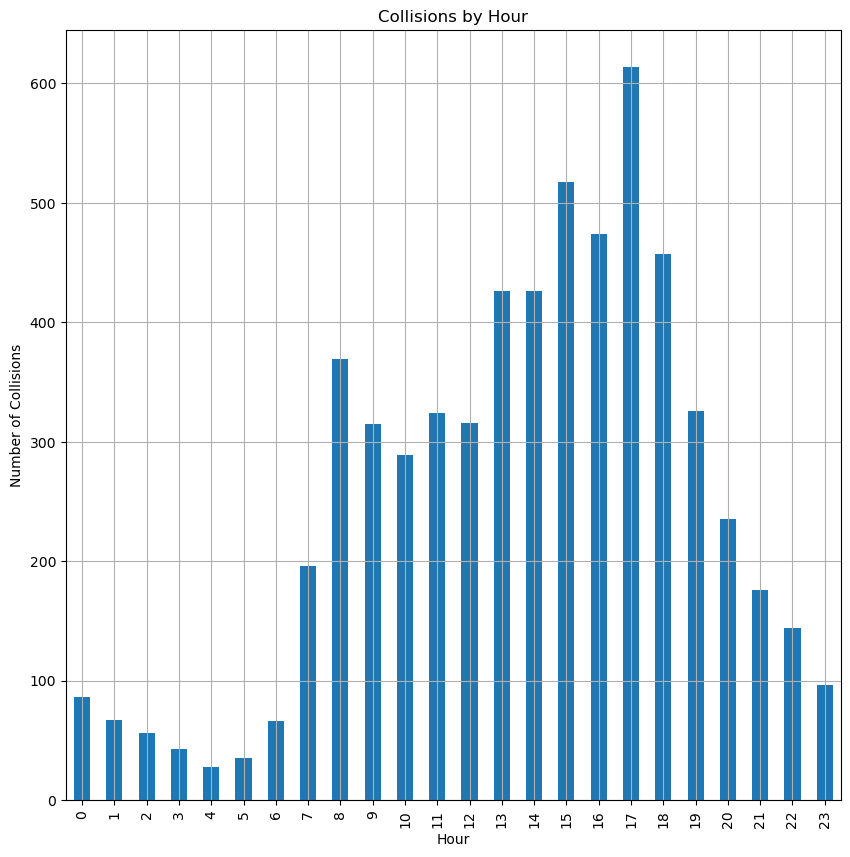

In [174]:
#Collisions by Hour
dfCol['a_hour'].value_counts().sort_index().plot(kind='bar', figsize=(10,10))
plt.title('Collisions by Hour')
plt.xlabel('Hour')
plt.ylabel('Number of Collisions')
plt.grid(True)
plt.show()

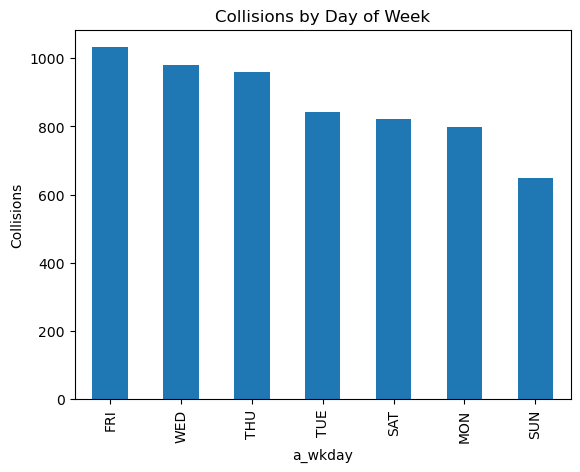

In [176]:
#Collisions by Day of Week
dfCol['a_wkday'].value_counts().plot(kind='bar')
plt.title('Collisions by Day of Week')
plt.ylabel('Collisions')
plt.show()

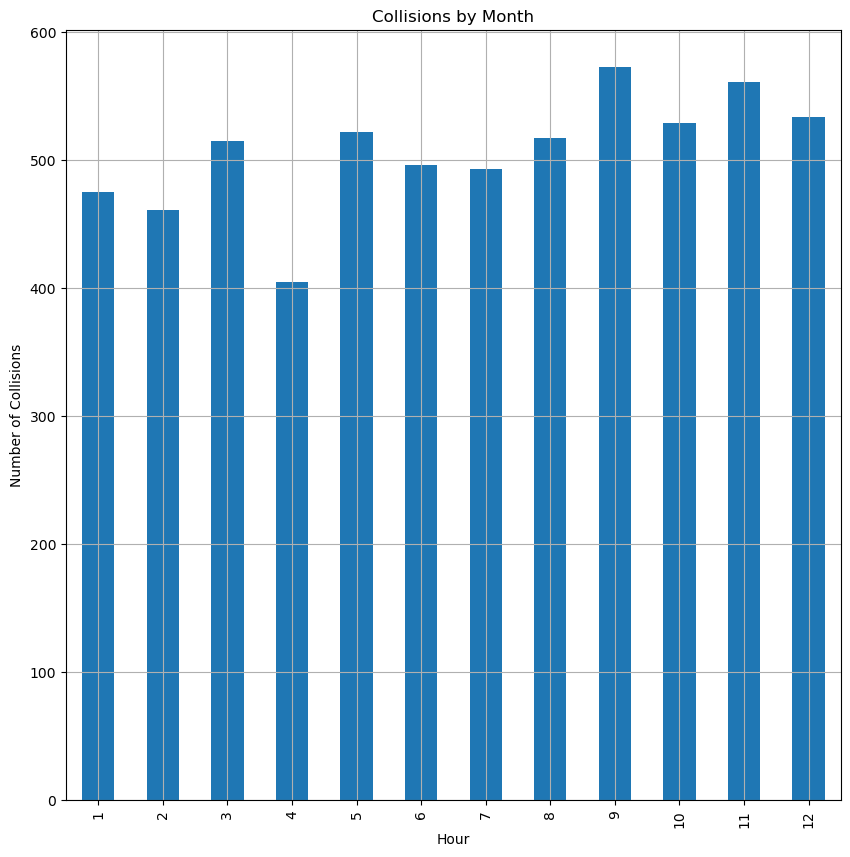

In [178]:
#Collisions by Month
dfCol['a_month'].value_counts().sort_index().plot(kind='bar', figsize=(10,10))
plt.title('Collisions by Month')
plt.xlabel('Hour')
plt.ylabel('Number of Collisions')
plt.grid(True)
plt.show()

In [65]:
# Create a transformer from Irish Grid (EPSG:29903) to WGS84 (EPSG:4326)
transformer = Transformer.from_crs("EPSG:29903", "EPSG:4326", always_xy=True)

# Convert Easting/Northing to Longitude/Latitude
# The transformer returns (longitude, latitude)
dfCol['longitude'], dfCol['latitude'] = transformer.transform(
    dfCol['a_gd1'].values,
    dfCol['a_gd2'].values
)

# View the results
print(dfCol[['a_gd1', 'a_gd2', 'longitude', 'latitude']].head(10))

    a_gd1   a_gd2  longitude   latitude
0  339189  339097  -5.863640  54.281742
1  305164  401602  -6.363452  54.851131
2  288498  345801  -6.639651  54.353228
3  334975  380862  -5.909253  54.657811
4  313692  389836  -6.235357  54.743628
5  353373  375446  -5.627257  54.603946
6  327818  363612  -6.027577  54.504807
7  321640  399559  -6.107941  54.829062
8  267513  409174  -6.947728  54.925622
9  311983  396730  -6.259224  54.805910
